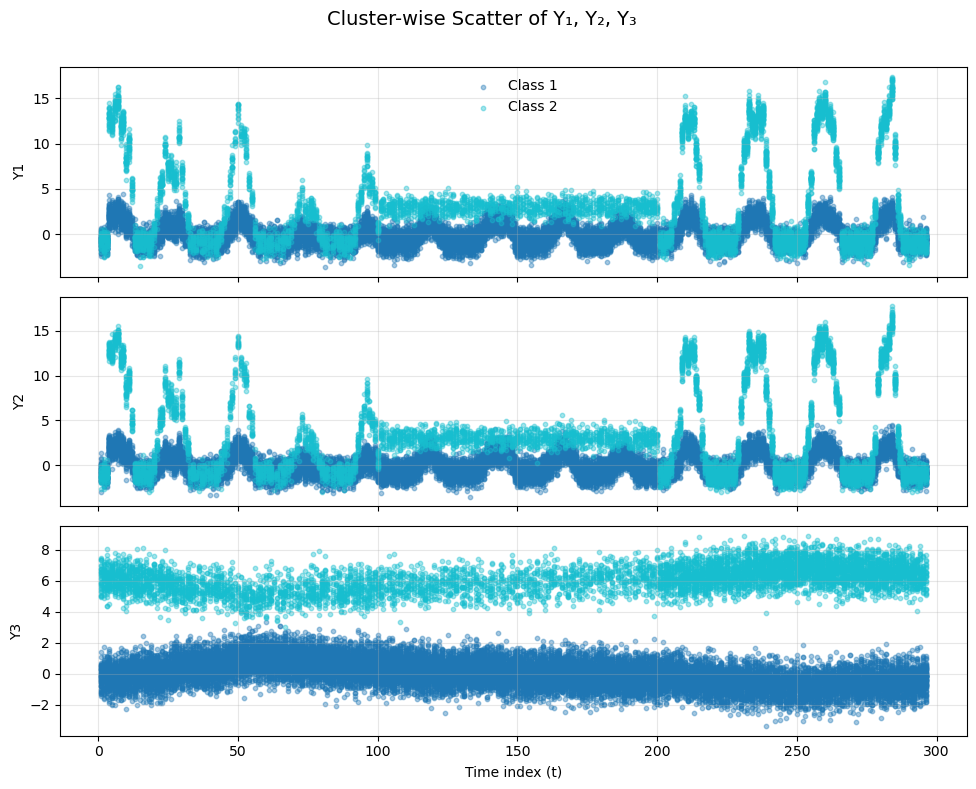

In [47]:
import torch, random, io, sys, warnings
import os, numpy as np, pandas as pd, pyreadr, matplotlib.pyplot as plt
from scipy.special import softmax
from data_generator import generate_gmm_data_segments
from tqdm import tqdm
from cpd_model import parse_args, learn_one_seq_penalty


os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"


import pyreadr


Y = pyreadr.read_r("sim_dat_ult.RDS")

X = pyreadr.read_r("sim_x_ult.RDS")

Y_df = np.array(list(Y.values())[0])
X_df = np.array(list(X.values())[0])

X_rep = np.repeat(X_df[:, np.newaxis, :], 100, axis=1)
Y = Y_df[:,:,0:3]
X = X_rep

import numpy as np
import matplotlib.pyplot as plt

T = Y_df.shape[0]
labels = np.unique(Y_df[:, :, 3].astype(int))
colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
dims = ['Y1', 'Y2', 'Y3']

for d in range(3):
    ax = axes[d]
    for j, lab in enumerate(labels):
        mask = (Y_df[:, :, 3] == lab)
        Y_vals = np.where(mask, Y_df[:, :, d], np.nan)
        t_vals = np.repeat(np.arange(1, T + 1)[:, None], Y_df.shape[1], axis=1)
        ax.scatter(t_vals[mask], Y_vals[mask],
                   color=colors[j], alpha=0.4, s=10, label=f"Class {lab}" if d == 0 else None)
    ax.set_ylabel(dims[d])
    ax.grid(True, alpha=0.3)
    if d == 2:
        ax.set_xlabel("Time index (t)")

axes[0].legend(frameon=False)
fig.suptitle("Cluster-wise Scatter of Y₁, Y₂, Y₃", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()





[INFO] Using device: cuda
Epoch   5 | Loss=1198.873535 | Kurtosis=2.853377
Epoch  10 | Loss=1129.941284 | Kurtosis=3.346361
Epoch  15 | Loss=1095.501099 | Kurtosis=12.430502
Epoch  20 | Loss=1087.654175 | Kurtosis=36.830254
Epoch  25 | Loss=1087.723267 | Kurtosis=47.186607
Epoch  30 | Loss=1088.008667 | Kurtosis=59.942455
Epoch  35 | Loss=1088.793579 | Kurtosis=55.641834
Epoch  40 | Loss=1088.251709 | Kurtosis=63.786648
Epoch  45 | Loss=1088.452271 | Kurtosis=97.847618
Epoch  50 | Loss=1091.111572 | Kurtosis=84.343575
Epoch  55 | Loss=1090.216431 | Kurtosis=103.149849
Epoch  60 | Loss=1091.138672 | Kurtosis=95.659164
Epoch  65 | Loss=1091.197998 | Kurtosis=112.858818
Epoch  70 | Loss=1091.750732 | Kurtosis=108.831291
Epoch  75 | Loss=1091.416870 | Kurtosis=102.686836
Epoch  80 | Loss=1091.191895 | Kurtosis=125.345490
Epoch  85 | Loss=1090.455078 | Kurtosis=121.022263
Epoch  90 | Loss=1092.559814 | Kurtosis=144.042679
Epoch  95 | Loss=1092.416382 | Kurtosis=138.831055
Epoch 100 | Loss=1

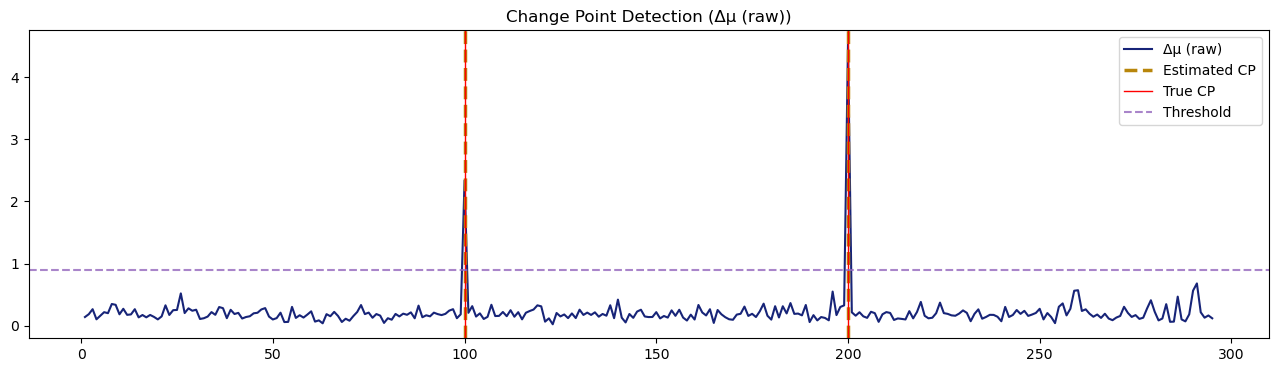

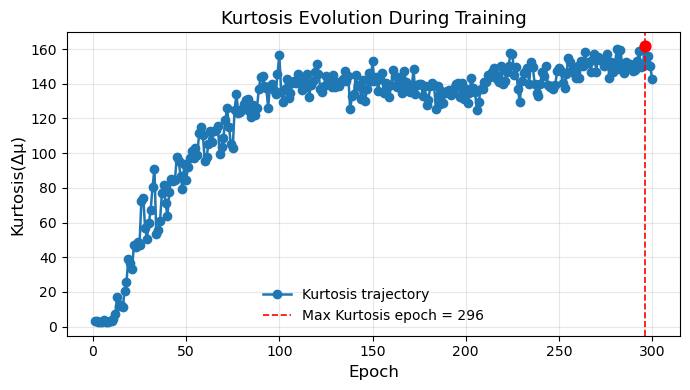

[INFO] Best epoch (max Kurtosis): 296, Kurtosis = 161.686554

[RESULT] True CPs = [100, 200]
[RESULT] Detected CPs = [100, 200]
[RESULT] Covering metric = 1.0000
[RESULT] abs_error = 0.0000


In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

# ======================================================
# 7. Prepare args
# ======================================================
args = parse_args()
args.epoch = 300
args.K_dim = 2
args.z_dim = 3
args.x_dim = X.shape[2]
args.y_dim = Y.shape[2]
args.num_time = X.shape[0]
args.num_samples = X.shape[1]
args.decoder_lr = 0.01
args.decoder_iteration = 20
args.langevin_s = 0.2
args.langevin_K = 1000
args.kappa = 0.8
args.penalties = [0.01, 0.1, 1]
args.nu_iteration = 20
args.output_layer = [50, 50]
args.scale_y = False
args.scale_delta = False
args.signif_level = 0.99
args.true_CP_full = [100,200]

# ======================================================
# 8. Prepare data tensors
# ======================================================


X_flat = X.reshape(-1, args.x_dim)
# X_mean, X_std = X_flat.mean(axis=0, keepdims=True), X_flat.std(axis=0, keepdims=True) + 1e-8
# X_flat = (X_flat - X_mean) / X_std
X_array = X_flat.reshape(args.num_time, -1, args.x_dim)

x_input = torch.tensor(X_array, dtype=torch.float32).to(device)
y_input = torch.tensor(Y.reshape(args.num_time, -1, args.y_dim), dtype=torch.float32).to(device)

# Split odd/even for penalty selection
odd_idx, even_idx = range(1, args.num_time, 2), range(0, args.num_time, 2)
x_train, x_test = x_input[odd_idx].reshape(-1, args.x_dim), x_input[even_idx].reshape(-1, args.x_dim)
y_train, y_test = y_input[odd_idx].reshape(-1, args.y_dim), y_input[even_idx].reshape(-1, args.y_dim)

# ======================================================
# 9. Penalty selection (half training)
# ======================================================
# results_half = []
# for penalty in args.penalties:
#     _stdout = sys.stdout
#     sys.stdout = io.StringIO()  # suppress printing
#     try:
#         loss, pen = learn_one_seq_penalty(args, x_train, y_train, x_test, y_test, penalty=penalty, half=True)
#     finally:
#         sys.stdout = _stdout
#     results_half.append([loss, pen])

# results_half = np.array(results_half)
# best_idx = np.argmin(results_half[:, 0])
# best_penalty = args.penalties[best_idx]
# print(f"[INFO] Best penalty selected = {best_penalty}")

# ======================================================
# 10. Full training using best penalty (record Kurtosis)
# ======================================================
result, kurt_list, delta_mu_all = learn_one_seq_penalty(
    args,
    x_input.reshape(-1, args.x_dim),
    y_input.reshape(-1, args.y_dim),
    x_input.reshape(-1, args.x_dim),
    y_input.reshape(-1, args.y_dim),
    penalty=0.05,
    half=False
)
torch.cuda.empty_cache()

# ======================================================
# 11. Plot Kurtosis trajectory
# ======================================================
import matplotlib.pyplot as plt
epochs = np.arange(1, len(kurt_list) + 1)
best_idx_kurt = int(np.argmax(kurt_list))
best_kurt = kurt_list[best_idx_kurt]

plt.figure(figsize=(7, 4))
plt.plot(epochs, kurt_list, marker='o', lw=1.8, label='Kurtosis trajectory')
plt.axvline(best_idx_kurt + 1, color='red', linestyle='--', lw=1.2,
            label=f'Max Kurtosis epoch = {best_idx_kurt + 1}')
plt.scatter(best_idx_kurt + 1, best_kurt, color='red', s=60, zorder=5)
plt.title("Kurtosis Evolution During Training", fontsize=13)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Kurtosis(Δμ)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

print(f"[INFO] Best epoch (max Kurtosis): {best_idx_kurt + 1}, Kurtosis = {best_kurt:.6f}")

# ======================================================
# 12. Report results
# ======================================================
print(f"\n[RESULT] True CPs = {args.true_CP_full}")
print(f"[RESULT] Detected CPs = {result[5]}")
print(f"[RESULT] Covering metric = {result[3]:.4f}")
print(f"[RESULT] abs_error = {result[0]:.4f}")

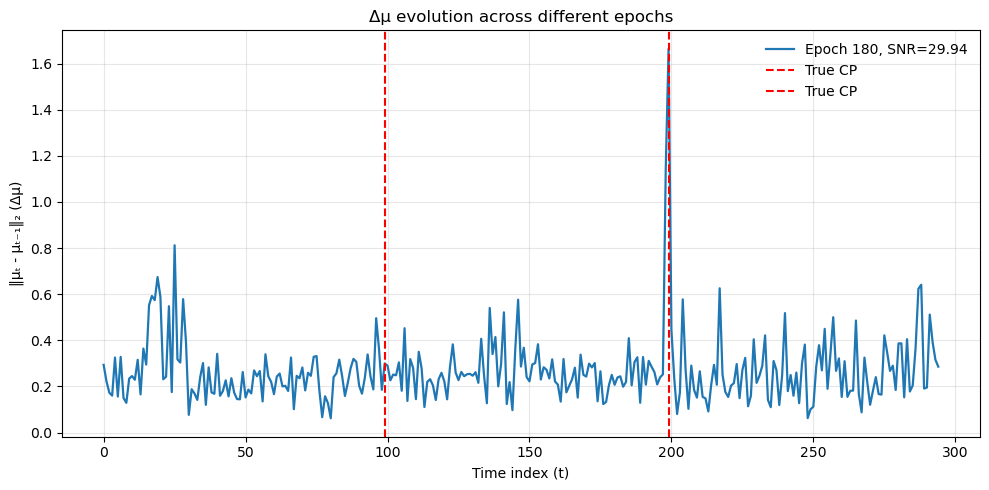

In [45]:
import matplotlib.pyplot as plt


epochs_to_show = [180]
plt.figure(figsize=(10, 5))

for e in epochs_to_show:
    if e <= len(delta_mu_all):
        plt.plot(delta_mu_all[e-1], lw=1.6, label=f"Epoch {e}, SNR={kurt_list[e-1]:.2f}")
for cp in [100,200]:
    plt.axvline(x=cp-1, color='red', linestyle='--', lw=1.5, label='True CP')
plt.xlabel("Time index (t)")
plt.ylabel("‖μₜ - μₜ₋₁‖₂ (Δμ)")
plt.title("Δμ evolution across different epochs")
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()



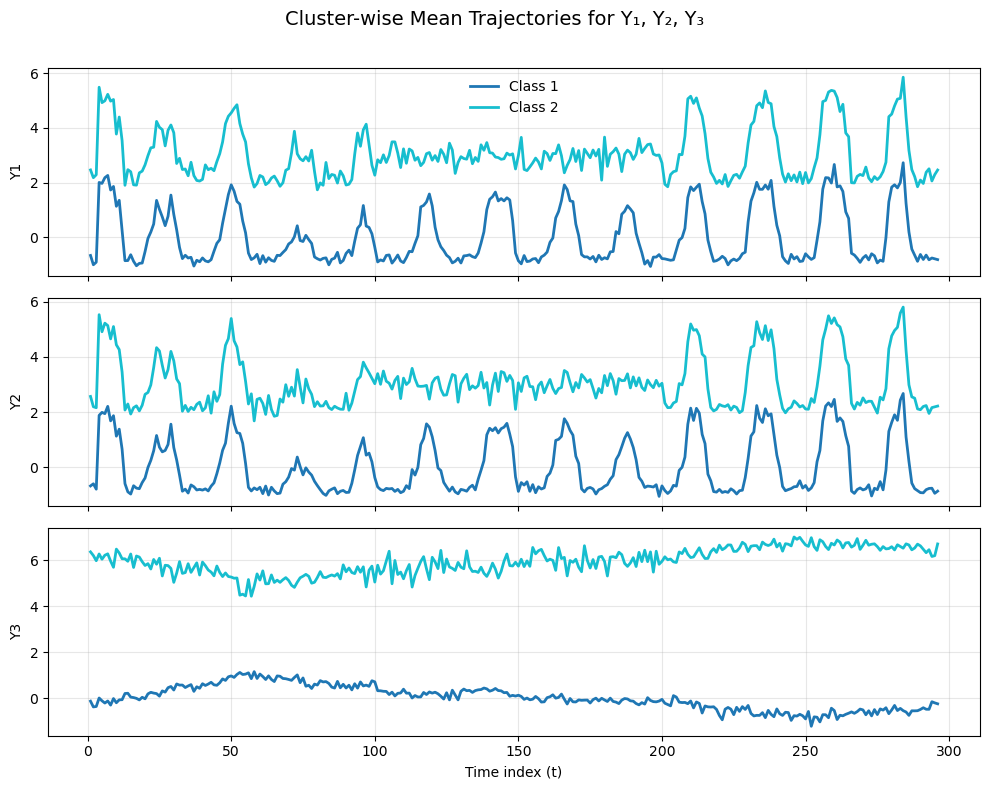

In [10]:
import numpy as np
import matplotlib.pyplot as plt

T = Y_df.shape[0]
labels = np.unique(Y_df[:, :, 3].astype(int))
colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))  
mean_traj = np.zeros((T, len(labels), 3))  # shape = (296, n_classes, 3)

for t in range(T):
    for j, lab in enumerate(labels):
        Y_t = Y_df[t, :, :3]
        idx = (Y_df[t, :, 3] == lab)
        if np.any(idx):
            mean_traj[t, j, :] = Y_t[idx].mean(axis=0)
        else:
            mean_traj[t, j, :] = np.nan  


fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
dims = ['Y1', 'Y2', 'Y3']

for d in range(3):
    ax = axes[d]
    for j, lab in enumerate(labels):
        ax.plot(range(1, T+1), mean_traj[:, j, d],
                color=colors[j], label=f"Class {lab}", lw=2)
    ax.set_ylabel(dims[d])
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(frameon=False)
    if d == 2:
        ax.set_xlabel("Time index (t)")

fig.suptitle("Cluster-wise Mean Trajectories for Y₁, Y₂, Y₃", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import imageio
from tqdm import tqdm


frames = []
cmap = plt.get_cmap("tab10")

save_dir = "frames"
import os
os.makedirs(save_dir, exist_ok=True)

for t in tqdm(range(Y_df.shape[0])):
    Y_t = Y_df[t, :, :3]
    labels_t = Y_df[t, :, 3].astype(int)

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")


    scatter = ax.scatter(Y_t[:, 0], Y_t[:, 1], Y_t[:, 2],
                         c=labels_t, cmap=cmap, s=30, alpha=0.8)

    ax.set_title(f"Time {t+1}", fontsize=12)
    ax.set_xlabel("Y1")
    ax.set_ylabel("Y2")
    ax.set_zlabel("Y3")


    ax.set_xlim(Y_df[:, :, 0].min(), Y_df[:, :, 0].max())
    ax.set_ylim(Y_df[:, :, 1].min(), Y_df[:, :, 1].max())
    ax.set_zlim(Y_df[:, :, 2].min(), Y_df[:, :, 2].max())

    plt.tight_layout()

    frame_path = f"{save_dir}/frame_{t:03d}.png"
    plt.savefig(frame_path, dpi=80)
    plt.close(fig)

    frames.append(frame_path)


images = [imageio.imread(f) for f in frames]
imageio.mimsave("Y_evolution.gif", images, fps=8) 



100%|██████████| 296/296 [00:24<00:00, 12.01it/s]
C:\Users\Qi\AppData\Local\Temp\ipykernel_18952\885736754.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f) for f in frames]


✅ GIF 已生成：Y_evolution.gif


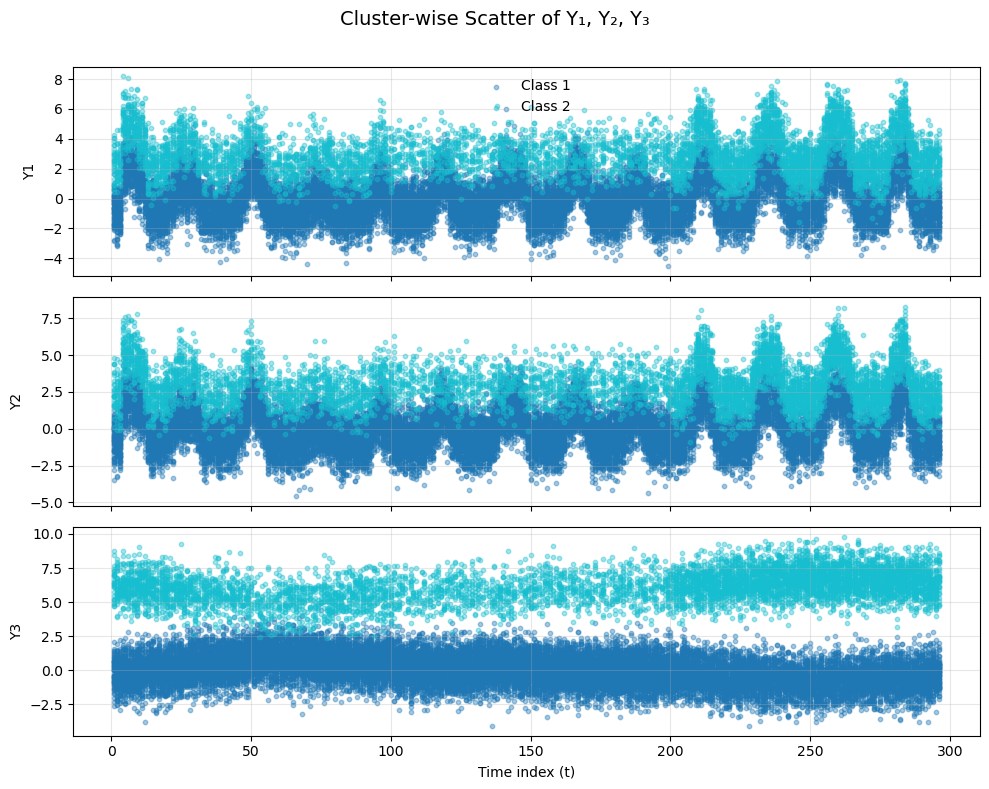